# [Bangk!t] Simple CNN
This kernel and the [kue indonesia](https://www.kaggle.com/ilhamfp31/kue-indonesia) dataset is part of Bangk!t final group assignment.   
In this kernel I'm trying a simple CNN as seen on [this](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow) course.  

**Final Group (BDG3-C):**  
[Annisa Sekar Ayuningtyas](https://www.linkedin.com/in/annisa-sekar-ayuningtyas-409112134/)  
[Ilham Firdausi Putra](https://www.linkedin.com/in/ilhamfp/)  

### What is Bangk!t?
Bangkit is a Google-led academy developed in collaboration with Gojek, Tokopedia, and Traveloka, designed to produce high-calibre, technical talent for world-class, Indonesian technology companies and startups.
More: https://events.withgoogle.com/bangkit/

## Let's take a look at the dataset

In [1]:
import os
kue_putri_salju_dir = os.path.join('../input/kue-indonesia/train/kue_putri_salju')
kue_klepon_dir = os.path.join('../input/kue-indonesia/train/kue_klepon')

print('total training kue putri salju images:', len(os.listdir(kue_putri_salju_dir)))
print('total training kue klepon images:', len(os.listdir(kue_klepon_dir)))

kue_putri_salju_files = os.listdir(kue_putri_salju_dir)
print(kue_putri_salju_files[:10])

kue_klepon_files = os.listdir(kue_klepon_dir)
print(kue_klepon_files[:10])

total training kue putri salju images: 174
total training kue klepon images: 200
['171.jpg', '138.jpg', '1.jpg', '81.jpg', '64.jpg', '16.jpg', '70.jpg', '53.jpg', '106.jpg', '103.jpg']
['66.jpg', '171.jpg', '138.jpg', '1.jpg', '81.jpg', '64.jpg', '16.jpg', '70.jpg', '53.jpg', '176.jpg']


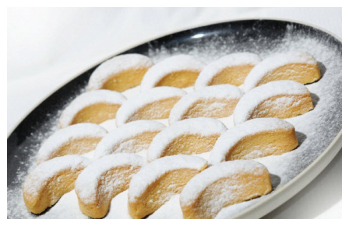

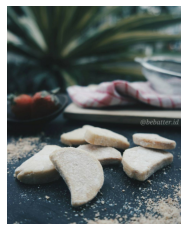

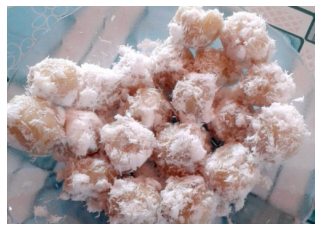

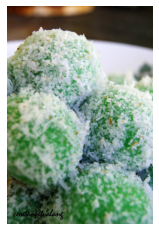

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 12

next_kue_putri_salju = [os.path.join(kue_putri_salju_dir, fname) 
                        for fname in kue_putri_salju_files[pic_index-2:pic_index]]
next_kue_klepon = [os.path.join(kue_klepon_dir, fname) 
                   for fname in kue_klepon_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_kue_putri_salju+next_kue_klepon):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Define Data

In [3]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

print("Loading training data...\t\t", end='')
TRAINING_DIR = "../input/kue-indonesia/train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=64
)

print("Loading validation data...\t\t", end='')
VALIDATION_DIR = "../input/kue-indonesia/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=16
)

print("Loading test data...\t\t\t", end='')
TEST_DIR = "../input/kue-indonesia/test/"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(150,150),
	class_mode='categorical',
    batch_size=16
)

Loading training data...		Found 1516 images belonging to 8 classes.
Loading validation data...		Found 160 images belonging to 8 classes.
Loading test data...			Found 160 images belonging to 8 classes.


## Define Model and Callbacks

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

def callbacks():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                       factor=0.5, patience=1, 
                                       verbose=1, mode='min', 
                                       epsilon=0.0001, min_lr=0,
                                       restore_best_weights=True)
    cb.append(reduceLROnPlat)
    
    log = CSVLogger('log.csv')
    cb.append(log)
    
    es = EarlyStopping(monitor='val_loss', patience=5, verbose=0,
                       mode='min', restore_best_weights=True)
    
    cb.append(es)
    
    return cb

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        9

## Train

In [6]:
## Calculate training time
import time
start = time.time()

In [7]:
history = model.fit(train_generator, 
                    epochs=200, 
                    validation_data = validation_generator, 
                    verbose = 1,
                    callbacks = callbacks())

Train for 24 steps, validate for 10 steps
Epoch 1/200
24/24 [==============================] - 82s 3s/step - loss: 1.8597 - accuracy: 0.2256 - val_loss: 1.5819 - val_accuracy: 0.3688
Epoch 2/200
24/24 [==============================] - 82s 3s/step - loss: 1.6763 - accuracy: 0.3311 - val_loss: 1.4580 - val_accuracy: 0.3812
Epoch 3/200
23/24 [===========================>..] - ETA: 3s - loss: 1.5887 - accuracy: 0.3616
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 [==============================] - 79s 3s/step - loss: 1.5821 - accuracy: 0.3654 - val_loss: 1.4751 - val_accuracy: 0.4437
Epoch 4/200
24/24 [==============================] - 87s 4s/step - loss: 1.4923 - accuracy: 0.4268 - val_loss: 1.4333 - val_accuracy: 0.4375
Epoch 5/200
23/24 [===========================>..] - ETA: 3s - loss: 1.4735 - accuracy: 0.4360
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
24/24 [==============================] - 79s 3s/step - l

In [8]:
print("Time elapsed training: ")
end = time.time()
print("{} second".format(end - start))

Time elapsed training: 
2342.6229298114777 second


In [9]:
model.save("model.h5")

## Plot training

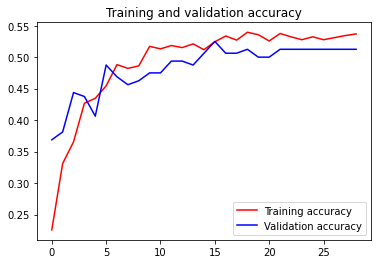

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Final Test

In [11]:
results = model.evaluate(test_generator)

10/10 [==============================] - 9s 888ms/step - loss: 1.0932 - accuracy: 0.6187


In [12]:
print('test loss, test acc:', results)

test loss, test acc: [1.0932281076908112, 0.61875]


## Thank you

Thank you so much for reading!